<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/Benchmark_spambase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.abod import ABOD
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn

##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Umap
import umap

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

     |████████████████████████████████| 102kB 3.7MB/s 
  Created wheel for pyod: filename=pyod-0.8.7-cp37-none-any.whl size=115979 sha256=ad5e2e84cc87e778c7cd5a68a466970734adcd6ddaa3234e2d8f655f65555fc2
  Stored in directory: /root/.cache/pip/wheels/b7/8a/c9/5fe3f32692ad445fe573cf5b953d7a0d55dc1f7c8e229ebda0
Successfully built pyod
     |████████████████████████████████| 153kB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for isotree: filename=isotree-0.2.7-cp37-cp37m-linux_x86_64.whl size=5786118 sha256=c3810c6b6cdd1fb3965eca68fcb4480c941e54f03fee9b80ec7da16adcc1fa16
  Stored in directory: /root/.cache/pip/wheels/1c/0d/3b/0f86713e664973c91dad4bfec9cc8a183560c45a1ff0146f19
Successfully built isotree


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Functions 

def train_test_split(full_dataframe, train_size, test_size, random_state = 1):
    train_set = full_dataframe.sample(random_state = random_state, n = train_size)
    train_X = train_set.drop('original.label', axis = 1) 
    train_y = train_set['original.label']
    
    test_set = full_dataframe.drop(train_set.index).sample(random_state = random_state, n = test_size)
    test_X = test_set.drop('original.label', axis = 1)
    test_y = test_set['original.label']
    return train_X, test_X, train_y, test_y

def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)
    
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
  
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
    
    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))
    
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [4]:
bm_922 = pd.read_csv("spambase_benchmark_0922.csv")
bm_943 = pd.read_csv("spambase_benchmark_0943.csv")
bm_944 = pd.read_csv("spambase_benchmark_0944.csv")

bm_922 = bm_922.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
bm_944 = bm_944.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
bm_943 = bm_943.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)

# BM_922 : scattered 

In [5]:
train_X, test_X, train_y, test_y = train_test_split(bm_922, 1170, 760, 42)

In [6]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [7]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.006837606837606838
Percentage Test Set Contamination:      0.011842105263157895


ABOD

---

In [43]:
get_prediction(ABOD(contamination = 0.01, n_neighbors=5), 
               train_X, test_X, train_y, test_y, 'IForest')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


On Training Data:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

In [ ]:
#Did not work yet
#error code

IForest

---



On Training Data:
IForest ROC:0.7324, precision @ rank n:0.1

On Test Data:
IForest ROC:0.8814, precision @ rank n:0.2857

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.20      0.29      0.24         7

    accuracy                           0.98       760
   macro avg       0.60      0.64      0.61       760
weighted avg       0.99      0.98      0.98       760


 IForest Matthews Correlation Coefficient 0.23061675793546044

 IForest f1-score 0.23529411764705882


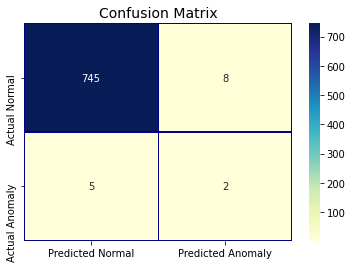

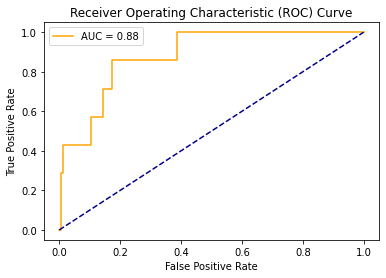

In [88]:
get_prediction(IForest(n_estimators = 50, max_samples = 'auto', contamination = 0.01, random_state= 42), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.5642, precision @ rank n:0.5393

On Test Data:
IForest ROC:0.7585, precision @ rank n:0.1429

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.11      0.14      0.12         7

    accuracy                           0.98       760
   macro avg       0.55      0.57      0.56       760
weighted avg       0.98      0.98      0.98       760


 IForest Matthews Correlation Coefficient 0.11677370151320951

 IForest f1-score 0.125


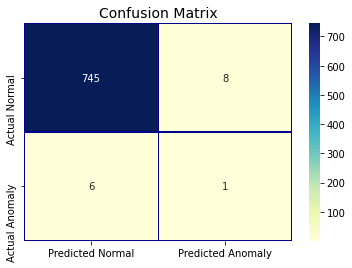

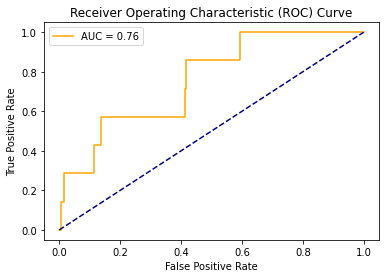

In [89]:
get_prediction(IForest(n_estimators = 25, max_samples = 'auto', contamination = 0.01, random_state=42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

OCSVM

---



On Training Data:
OCSVM ROC:0.5092, precision @ rank n:0.4802

On Test Data:
OCSVM ROC:0.5221, precision @ rank n:0.1111

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       751
           1       0.33      0.11      0.17         9

    accuracy                           0.99       760
   macro avg       0.66      0.55      0.58       760
weighted avg       0.98      0.99      0.98       760


 OCSVM Matthews Correlation Coefficient 0.18709155486814066

 OCSVM f1-score 0.16666666666666666


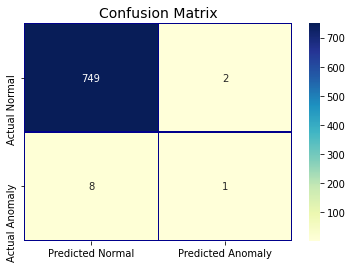

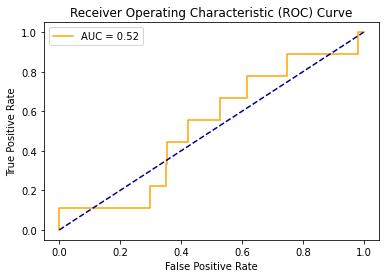

In [56]:
get_prediction(OCSVM(gamma = 0.001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.7119, precision @ rank n:0.25

On Test Data:
OCSVM ROC:0.6113, precision @ rank n:0.1111

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       751
           1       0.08      0.11      0.10         9

    accuracy                           0.97       760
   macro avg       0.54      0.55      0.54       760
weighted avg       0.98      0.97      0.98       760


 OCSVM Matthews Correlation Coefficient 0.08370761160406405

 OCSVM f1-score 0.09523809523809525


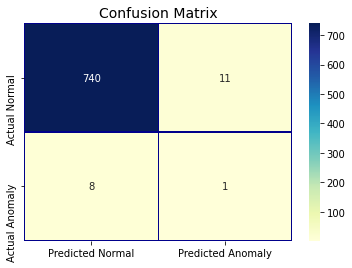

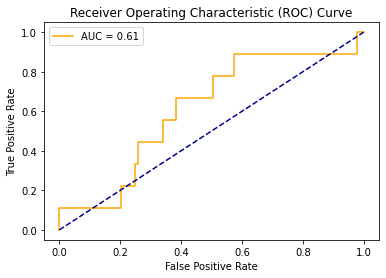

In [55]:
get_prediction(OCSVM(gamma = 'auto', contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

LOF

---



On Training Data:
LOF ROC:0.863, precision @ rank n:0.25

On Test Data:
LOF ROC:0.7155, precision @ rank n:0.1111

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       751
           1       0.12      0.11      0.12         9

    accuracy                           0.98       760
   macro avg       0.56      0.55      0.55       760
weighted avg       0.98      0.98      0.98       760


 LOF Matthews Correlation Coefficient 0.10789300801375233

 LOF f1-score 0.11764705882352941


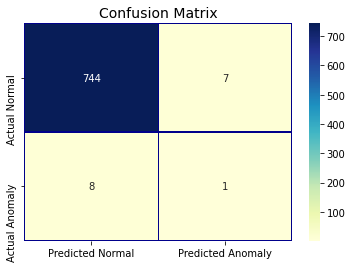

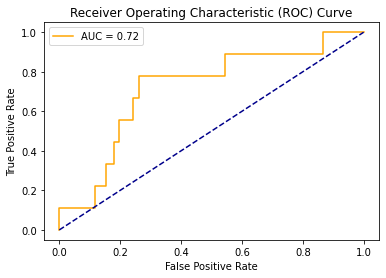

In [37]:
get_prediction(LOF(n_neighbors=75, contamination= 0.01, algorithm='auto', metric = 'cityblock'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.0953, precision @ rank n:0.1429

On Test Data:
LOF ROC:0.6539, precision @ rank n:0.1111

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       751
           1       0.06      0.11      0.08         9

    accuracy                           0.97       760
   macro avg       0.53      0.55      0.53       760
weighted avg       0.98      0.97      0.97       760


 LOF Matthews Correlation Coefficient 0.06867410842900863

 LOF f1-score 0.08


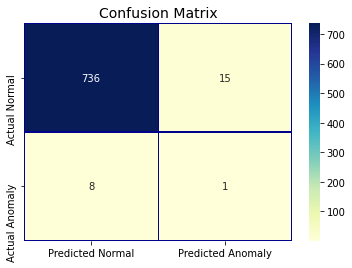

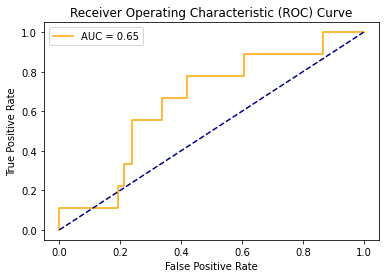

In [39]:
get_prediction(LOF(n_neighbors=75, contamination= 0.01, algorithm='auto', metric = 'cityblock'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

CBLOF

---



On Training Data:
CBLOF ROC:0.691, precision @ rank n:0.25

On Test Data:
CBLOF ROC:0.5948, precision @ rank n:0.1111

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       751
           1       0.10      0.11      0.11         9

    accuracy                           0.98       760
   macro avg       0.54      0.55      0.55       760
weighted avg       0.98      0.98      0.98       760


 CBLOF Matthews Correlation Coefficient 0.09410288707589759

 CBLOF f1-score 0.10526315789473685


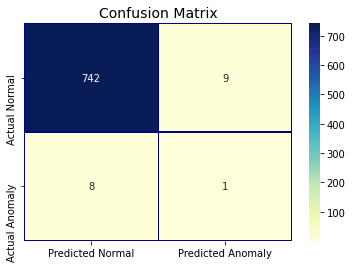

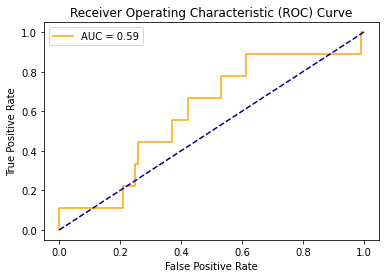

In [51]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 15, alpha= 0.8, beta= 15), 
               train_X, test_X, train_y, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.318, precision @ rank n:0.3115

On Test Data:
CBLOF ROC:0.5729, precision @ rank n:0.1111

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       751
           1       1.00      0.11      0.20         9

    accuracy                           0.99       760
   macro avg       0.99      0.56      0.60       760
weighted avg       0.99      0.99      0.99       760


 CBLOF Matthews Correlation Coefficient 0.331571982388737

 CBLOF f1-score 0.19999999999999998


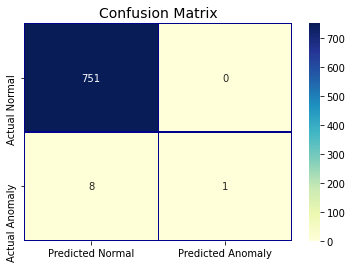

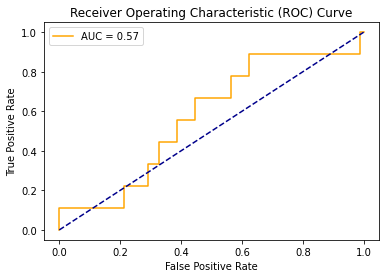

In [52]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 20, alpha= 0.8, beta= 15), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

KNN

---



On Training Data:
KNN ROC:0.7815, precision @ rank n:0.25

On Test Data:
KNN ROC:0.693, precision @ rank n:0.1111

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       751
           1       0.10      0.11      0.11         9

    accuracy                           0.98       760
   macro avg       0.54      0.55      0.55       760
weighted avg       0.98      0.98      0.98       760


 KNN Matthews Correlation Coefficient 0.09410288707589759

 KNN f1-score 0.10526315789473685


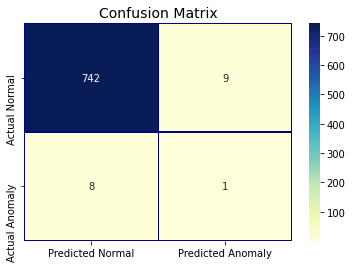

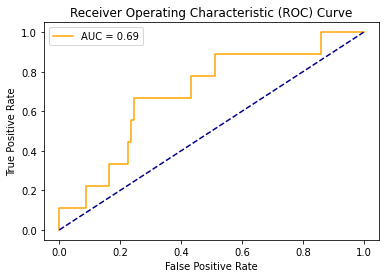

In [57]:
get_prediction(KNN(n_neighbors= 5, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.3388, precision @ rank n:0.3546

On Test Data:
KNN ROC:0.5495, precision @ rank n:0.1111

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       751
           1       1.00      0.11      0.20         9

    accuracy                           0.99       760
   macro avg       0.99      0.56      0.60       760
weighted avg       0.99      0.99      0.99       760


 KNN Matthews Correlation Coefficient 0.331571982388737

 KNN f1-score 0.19999999999999998


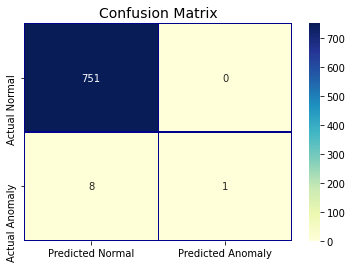

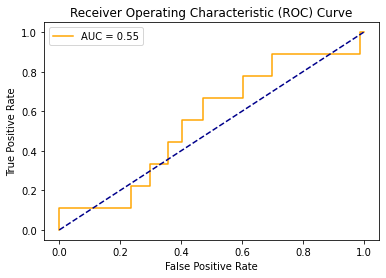

In [67]:
get_prediction(KNN(n_neighbors= 150, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.43      0.43      0.43         7

    accuracy                           0.99       760
   macro avg       0.71      0.71      0.71       760
weighted avg       0.99      0.99      0.99       760


 IForest  Confusion Matrix: 
 [[749   4]
 [  4   3]]

 IForest Matthews Correlation Coefficient 0.42325934357806866

 IForest f1-score 0.42857142857142855


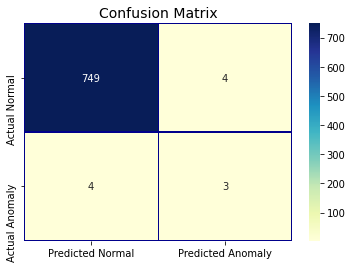

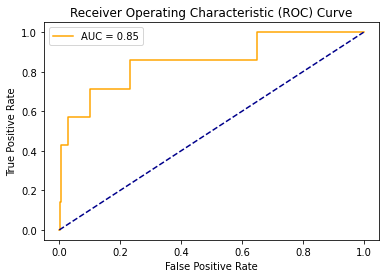

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       753
           1       1.00      0.29      0.44         7

    accuracy                           0.99       760
   macro avg       1.00      0.64      0.72       760
weighted avg       0.99      0.99      0.99       760


 SciForest  Confusion Matrix: 
 [[753   0]
 [  5   2]]

 SciForest Matthews Correlation Coefficient 0.5327566300268279

 SciForest f1-score 0.4444444444444445


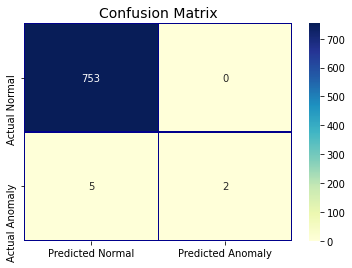

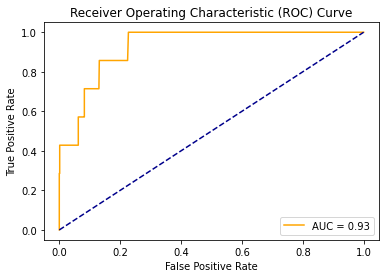

In [ ]:

get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

# BM_944 : least clustered 

In [68]:
train_X, test_X, train_y, test_y = train_test_split(bm_944, 1170, 760, 42)

In [69]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [70]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.008547008547008548
Percentage Test Set Contamination:      0.009210526315789473


ABOD

---

In [ ]:
get_prediction(ABOD(contamination = 0.01, n_neighbors= 5, method='fast'), 
               train_X, test_X, train_y, test_y, 'ABOD')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


On Training Data:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

## IForest

---



On Training Data:
IForest ROC:0.7975, precision @ rank n:0.1

On Test Data:
IForest ROC:0.8907, precision @ rank n:0.1667

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.20      0.14      0.17         7

    accuracy                           0.99       760
   macro avg       0.60      0.57      0.58       760
weighted avg       0.98      0.99      0.99       760


 IForest Matthews Correlation Coefficient 0.16252980731308903

 IForest f1-score 0.16666666666666666


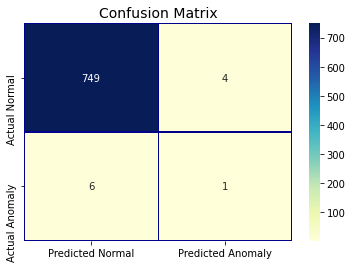

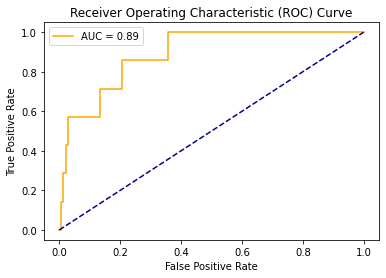

In [86]:
get_prediction(IForest(n_estimators = 12, max_samples = 2048, contamination = 0.01, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.5817, precision @ rank n:0.5633

On Test Data:
IForest ROC:0.7323, precision @ rank n:0.1429

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.11      0.14      0.12         7

    accuracy                           0.98       760
   macro avg       0.55      0.57      0.56       760
weighted avg       0.98      0.98      0.98       760


 IForest Matthews Correlation Coefficient 0.11677370151320951

 IForest f1-score 0.125


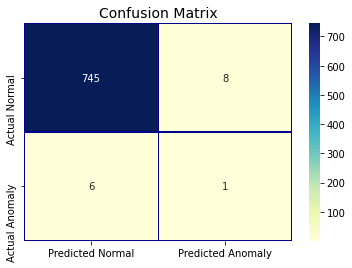

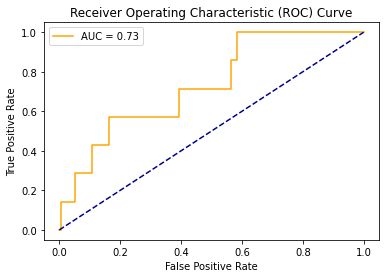

In [87]:
get_prediction(IForest(n_estimators = 25, max_samples = 128, contamination = 0.01, random_state=42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.1821, precision @ rank n:0.2256

On Test Data:
OCSVM ROC:0.6282, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.57      0.73       753
           1       0.02      0.71      0.03         7

    accuracy                           0.57       760
   macro avg       0.51      0.64      0.38       760
weighted avg       0.99      0.57      0.72       760


 OCSVM Matthews Correlation Coefficient 0.05503291697979676

 OCSVM f1-score 0.029850746268656716


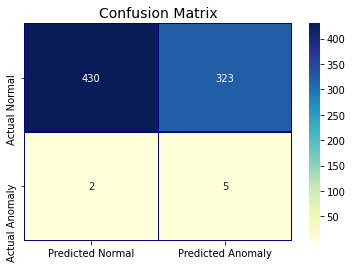

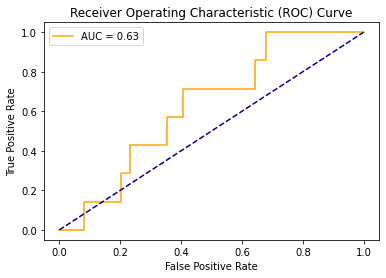

In [92]:
get_prediction(OCSVM(gamma = 0.3, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.5938, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.7035, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.38      0.55       753
           1       0.01      1.00      0.03         7

    accuracy                           0.39       760
   macro avg       0.51      0.69      0.29       760
weighted avg       0.99      0.39      0.55       760


 OCSVM Matthews Correlation Coefficient 0.07489371567796563

 OCSVM f1-score 0.029106029106029108


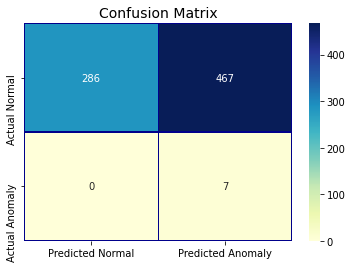

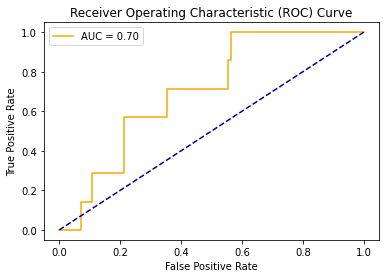

In [93]:
get_prediction(OCSVM(gamma = 0.3, contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.8543, precision @ rank n:0.3333

On Test Data:
LOF ROC:0.6585, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       753
           1       0.00      0.00      0.00         7

    accuracy                           0.99       760
   macro avg       0.50      0.50      0.50       760
weighted avg       0.98      0.99      0.99       760


 LOF Matthews Correlation Coefficient 0.0

 LOF f1-score 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


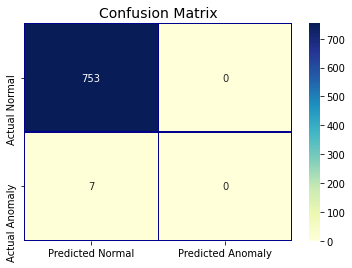

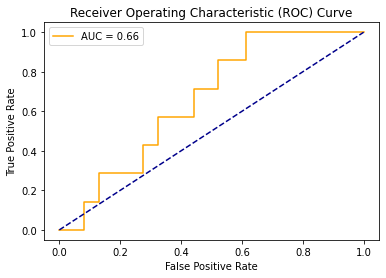

In [74]:
get_prediction(LOF(n_neighbors=75, contamination= 0.01, algorithm='auto', metric = 'cosine'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.3655, precision @ rank n:0.3838

On Test Data:
LOF ROC:0.7196, precision @ rank n:0.1429

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.12      0.14      0.13         7

    accuracy                           0.98       760
   macro avg       0.56      0.57      0.56       760
weighted avg       0.98      0.98      0.98       760


 LOF Matthews Correlation Coefficient 0.12501791085750233

 LOF f1-score 0.13333333333333333


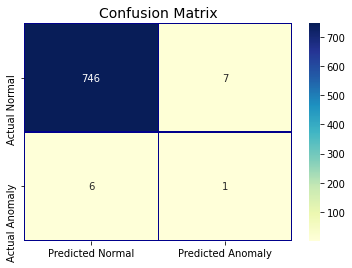

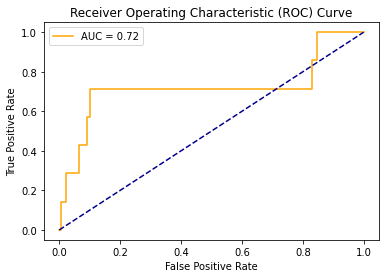

In [73]:
get_prediction(LOF(n_neighbors=75, contamination= 0.01, algorithm='auto', metric = 'cosine'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.1263, precision @ rank n:0.2022

On Test Data:
CBLOF ROC:0.4984, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.00      0.00      0.00         7

    accuracy                           0.98       760
   macro avg       0.50      0.49      0.49       760
weighted avg       0.98      0.98      0.98       760


 CBLOF Matthews Correlation Coefficient -0.010554868285985938

 CBLOF f1-score 0.0


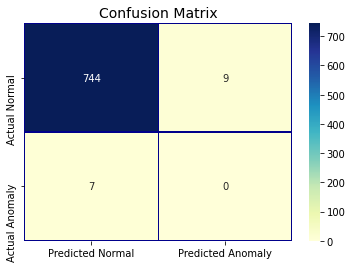

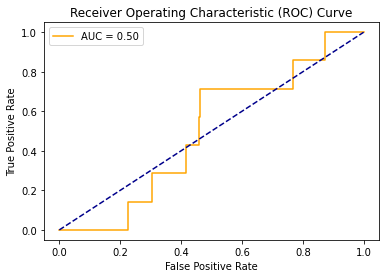

In [75]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 75, alpha= 0.8, beta= 15), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.7336, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.7052, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.00      0.00      0.00         7

    accuracy                           0.99       760
   macro avg       0.50      0.50      0.50       760
weighted avg       0.98      0.99      0.98       760


 CBLOF Matthews Correlation Coefficient -0.007013271145531147

 CBLOF f1-score 0.0


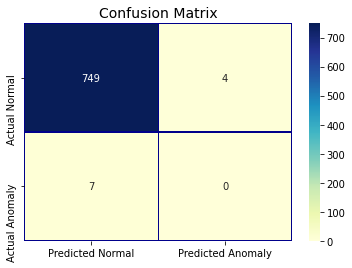

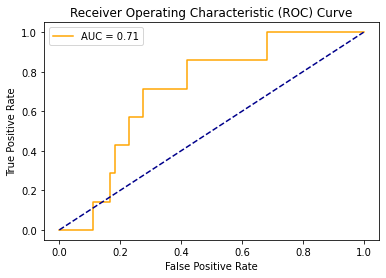

In [82]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 75, alpha= 0.8, beta= 15), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.744, precision @ rank n:0.0

On Test Data:
KNN ROC:0.735, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.00      0.00      0.00         7

    accuracy                           0.98       760
   macro avg       0.50      0.50      0.50       760
weighted avg       0.98      0.98      0.98       760


 KNN Matthews Correlation Coefficient -0.008600852190079502

 KNN f1-score 0.0


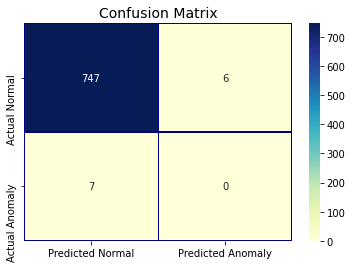

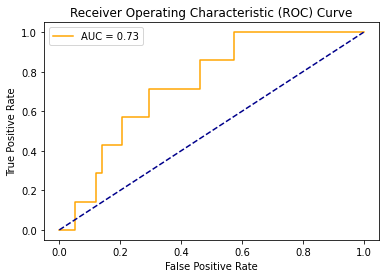

In [91]:
get_prediction(KNN(n_neighbors= 5, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.0941, precision @ rank n:0.1106

On Test Data:
KNN ROC:0.564, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.00      0.00      0.00         7

    accuracy                           0.98       760
   macro avg       0.50      0.49      0.49       760
weighted avg       0.98      0.98      0.98       760


 KNN Matthews Correlation Coefficient -0.01168441478614841

 KNN f1-score 0.0


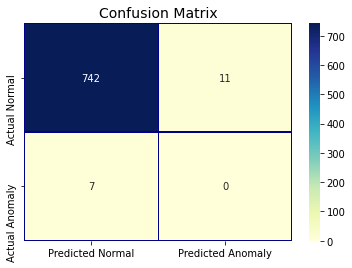

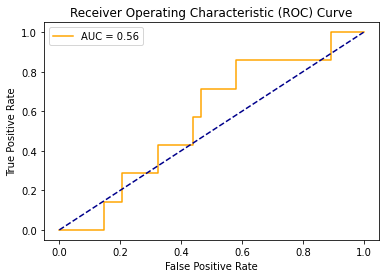

In [90]:
get_prediction(KNN(n_neighbors= 10, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.43      0.43      0.43         7

    accuracy                           0.99       760
   macro avg       0.71      0.71      0.71       760
weighted avg       0.99      0.99      0.99       760


 IForest  Confusion Matrix: 
 [[749   4]
 [  4   3]]

 IForest Matthews Correlation Coefficient 0.42325934357806866

 IForest f1-score 0.42857142857142855


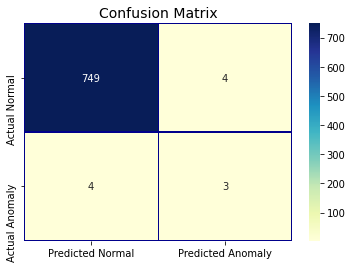

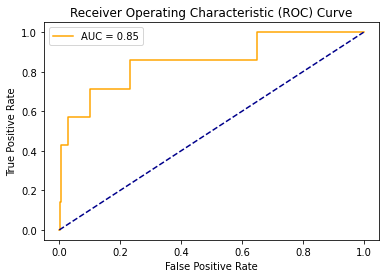

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       753
           1       1.00      0.29      0.44         7

    accuracy                           0.99       760
   macro avg       1.00      0.64      0.72       760
weighted avg       0.99      0.99      0.99       760


 SciForest  Confusion Matrix: 
 [[753   0]
 [  5   2]]

 SciForest Matthews Correlation Coefficient 0.5327566300268279

 SciForest f1-score 0.4444444444444445


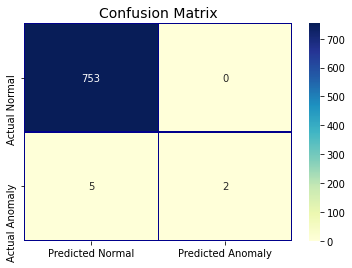

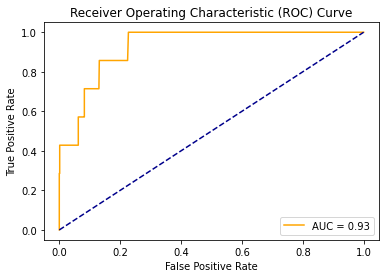

In [ ]:

get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

# BM_943 : most clustered 

In [94]:
train_X, test_X, train_y, test_y = train_test_split(bm_943, 1170, 760, 42)

In [95]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [96]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.01282051282051282
Percentage Test Set Contamination:      0.010526315789473684


ABOD

---

In [ ]:
get_prediction(ABOD(contamination = 0.01, n_neighbors= 5, method='fast'), 
               train_X, test_X, train_y, test_y, 'ABOD')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


On Training Data:


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: ignored

## IForest

---



On Training Data:
IForest ROC:0.6225, precision @ rank n:0.0

On Test Data:
IForest ROC:0.6078, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.99       760
   macro avg       0.49      0.50      0.50       760
weighted avg       0.98      0.99      0.98       760


 IForest Matthews Correlation Coefficient -0.005298055070114333

 IForest f1-score 0.0


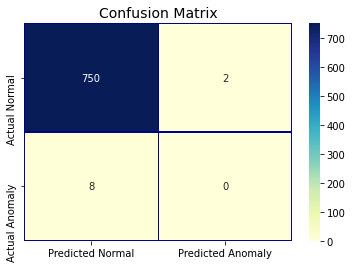

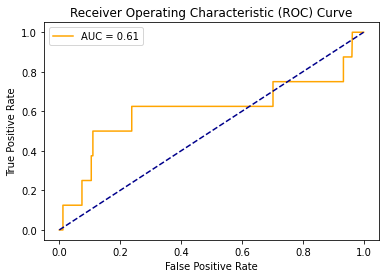

In [97]:
get_prediction(IForest(n_estimators = 50, max_samples = 128, contamination = 0.01, random_state= 42), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.3001, precision @ rank n:0.361

On Test Data:
IForest ROC:0.4601, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.97       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.97      0.98       760


 IForest Matthews Correlation Coefficient -0.013063991744674621

 IForest f1-score 0.0


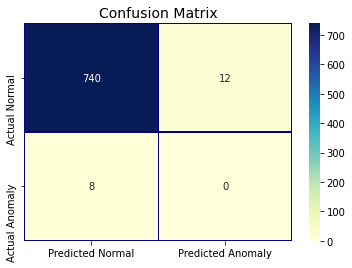

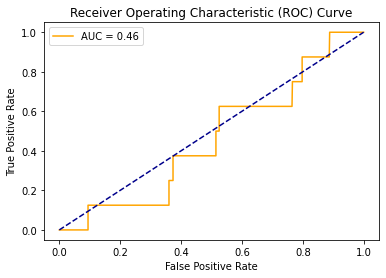

In [100]:
get_prediction(IForest(n_estimators = 25, max_samples = 2048, contamination = 0.01, random_state=42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.2084, precision @ rank n:0.2815

On Test Data:
OCSVM ROC:0.3168, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.98       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.98      0.98       760


 OCSVM Matthews Correlation Coefficient -0.010638297872340425

 OCSVM f1-score 0.0


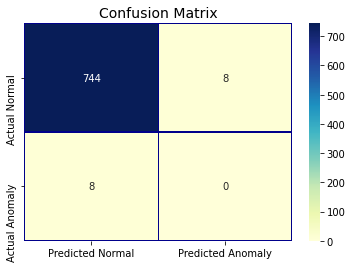

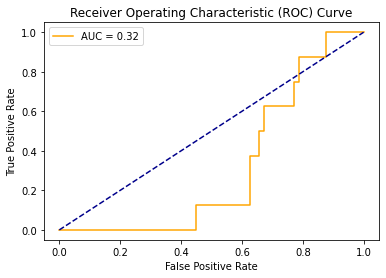

In [111]:
get_prediction(OCSVM(gamma = 0.001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.4199, precision @ rank n:0.0

On Test Data:
OCSVM ROC:0.3674, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       752
           1       0.00      0.00      0.00         8

    accuracy                           0.96       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.96      0.97       760


 OCSVM Matthews Correlation Coefficient -0.017386953849557508

 OCSVM f1-score 0.0


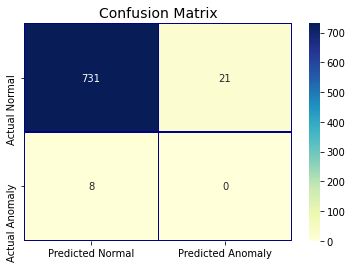

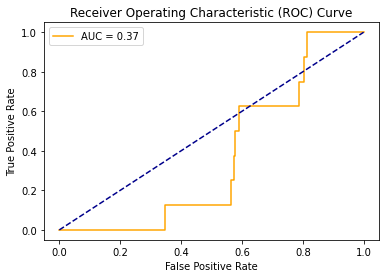

In [113]:
get_prediction(OCSVM(gamma = 0.03, contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.0614, precision @ rank n:0.1244

On Test Data:
LOF ROC:0.5519, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.98       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.98      0.98       760


 LOF Matthews Correlation Coefficient -0.011291128745625245

 LOF f1-score 0.0


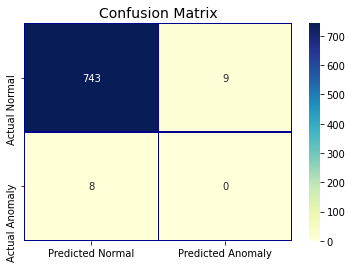

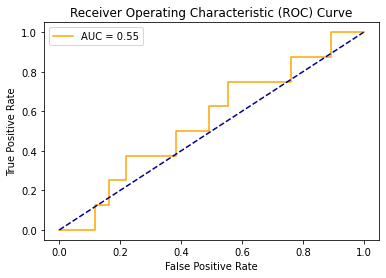

In [101]:
get_prediction(LOF(n_neighbors=75, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.7142, precision @ rank n:0.0

On Test Data:
LOF ROC:0.6001, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.99       760
   macro avg       0.49      0.50      0.50       760
weighted avg       0.98      0.99      0.98       760


 LOF Matthews Correlation Coefficient -0.0037438219415934153

 LOF f1-score 0.0


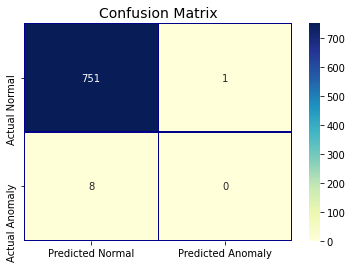

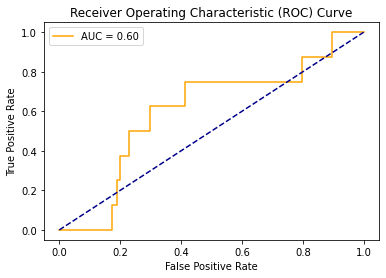

In [102]:
get_prediction(LOF(n_neighbors=150, contamination= 0.01, algorithm='auto', metric = 'cosine'), 
               train_X, test_X, train_y, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.1079, precision @ rank n:0.1762

On Test Data:
CBLOF ROC:0.3747, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.98       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.98      0.98       760


 CBLOF Matthews Correlation Coefficient -0.010638297872340425

 CBLOF f1-score 0.0


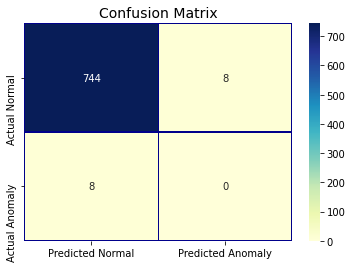

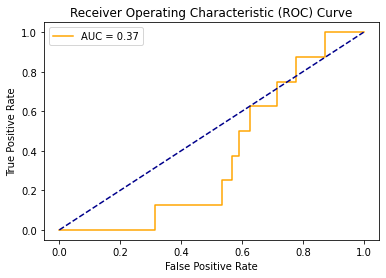

In [104]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 50, alpha= 0.9, beta= 15), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.4074, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.3504, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.99       760
   macro avg       0.49      0.50      0.50       760
weighted avg       0.98      0.99      0.98       760


 CBLOF Matthews Correlation Coefficient -0.0064930502036552856

 CBLOF f1-score 0.0


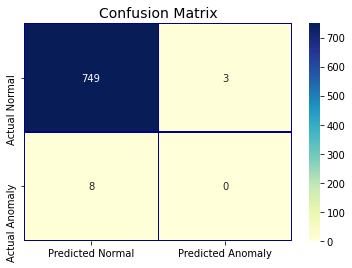

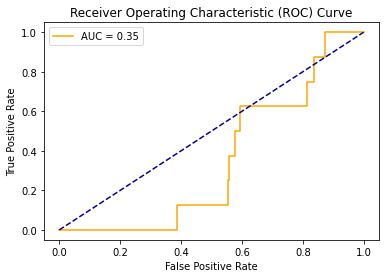

In [105]:
get_prediction(CBLOF(contamination= 0.01, n_clusters= 25, alpha= 0.8, beta= 15), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.0819, precision @ rank n:0.0959

On Test Data:
KNN ROC:0.3938, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.97       760
   macro avg       0.49      0.49      0.49       760
weighted avg       0.98      0.97      0.98       760


 KNN Matthews Correlation Coefficient -0.013063991744674621

 KNN f1-score 0.0


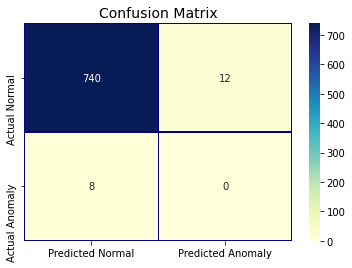

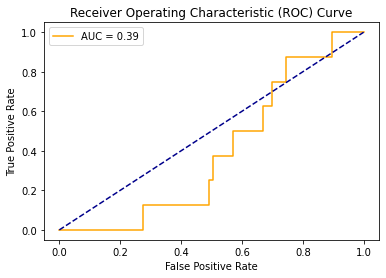

In [109]:
get_prediction(KNN(n_neighbors= 10, method= 'mean', algorithm='auto',contamination= 0.01), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

On Training Data:
KNN ROC:0.4286, precision @ rank n:0.0

On Test Data:
KNN ROC:0.3953, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       752
           1       0.00      0.00      0.00         8

    accuracy                           0.98       760
   macro avg       0.49      0.50      0.50       760
weighted avg       0.98      0.98      0.98       760


 KNN Matthews Correlation Coefficient -0.007502485610105728

 KNN f1-score 0.0


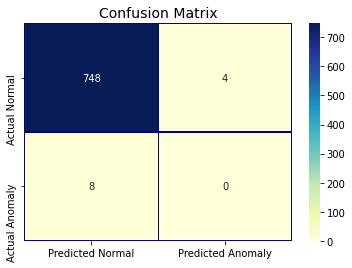

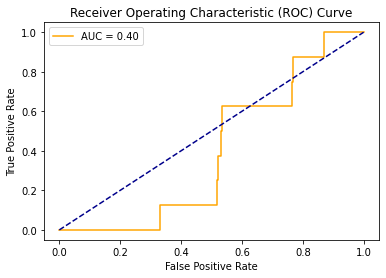

In [110]:
get_prediction(KNN(n_neighbors= 20, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       753
           1       0.43      0.43      0.43         7

    accuracy                           0.99       760
   macro avg       0.71      0.71      0.71       760
weighted avg       0.99      0.99      0.99       760


 IForest  Confusion Matrix: 
 [[749   4]
 [  4   3]]

 IForest Matthews Correlation Coefficient 0.42325934357806866

 IForest f1-score 0.42857142857142855


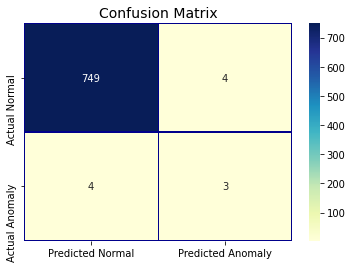

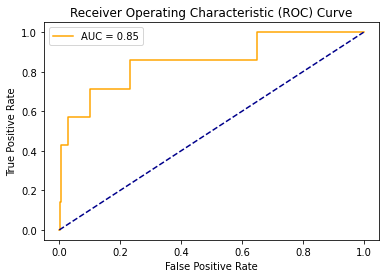

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       753
           1       1.00      0.29      0.44         7

    accuracy                           0.99       760
   macro avg       1.00      0.64      0.72       760
weighted avg       0.99      0.99      0.99       760


 SciForest  Confusion Matrix: 
 [[753   0]
 [  5   2]]

 SciForest Matthews Correlation Coefficient 0.5327566300268279

 SciForest f1-score 0.4444444444444445


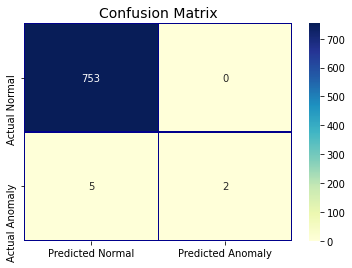

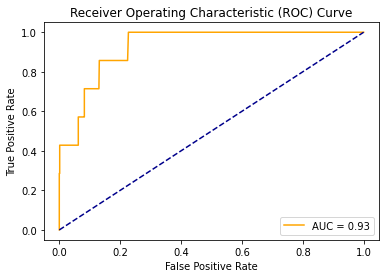

In [ ]:

get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')